In [ ]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Ruta al directorio
data_dir = Path("./captcha_images_v2/")

In [6]:
# Obtenemos la lista de todas las imágenes
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [7]:
# Tamaño del entrenamiento para lote y validación
# dado que tenemos pocos datos, el lote es pequeño para evitar el sobreajuste
batch_size = 16

# Dimensión de las imágenes a ingresar a la red
img_width = 200
img_height = 50

# Usaremos dos capas de convolución que reduce la imagen en un factor de 2
downsample_factor = 4

# Máximo de carácteres que tiene un captcha
max_length = max([len(label) for label in labels])

# Pre procesamiento ...

In [8]:
# mapeamos los carácteres para asignarles un número único
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# invertimos el mapeo para decodificar el mapeo anterior, para garantizar una correspondencia bidireccional
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [9]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    # matriz de índices
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)
    # dividimos la data
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    # leemos la imágene y lo pasamos a un solo canal
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    # reescalamos en [0,1] con tipo float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # redimensionamos
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    # mapeamos las etiquetas
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

# Guardamos en un dataset los datos transformados ...

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# visualizamos ...

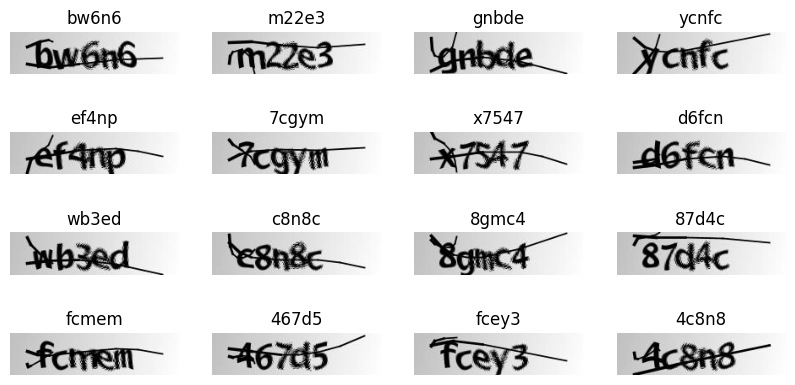

In [25]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    experiment.log_image(image_data=images, name=labels) # incluimos algunas imágenes en comet.ml
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Creamos el modelo o arquitectura ...

In [12]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Calcule el valor de pérdida de tiempo de entrenamiento y agréguelo
        # a la capa usando `self.add_loss()
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    # entrada
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # primera convolución
    x = layers.Conv2D(32,(3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # segunda convolución
    x = layers.Conv2D(64,(3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # conectamos las convoluciones con las redes recurrentes
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # salida
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # agregamos una capa de CTC a la salida
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Definimos el modelo
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    # Optimizador
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

# Entrenamiento ...

In [20]:
epochs = 100
early_stopping_patience = 10
# activamos la parada anticipada si es que en las siguientes 10 épocas
# no hay una mejora significativa
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Entrenando
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

In [ ]:
# Obtenga el modelo de predicción extrayendo capas hasta la capa de salida
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

1/1 [==============================] - 4s 4s/step


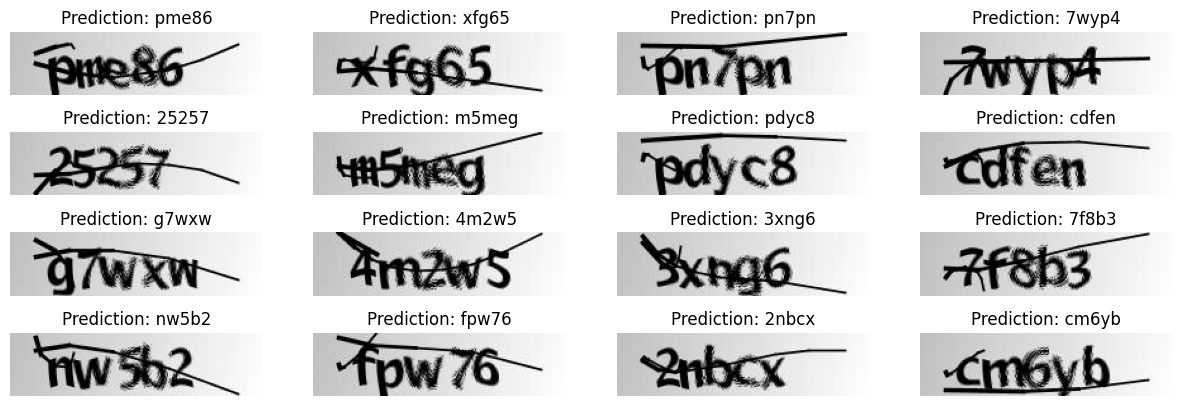

In [ ]:
# Decodificamos la salida de la red
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  verificamos los resultados
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()